## Notebook to to re-cluster on just a subset of selected cells

using Pegasus

In [1]:
!date

Mon Oct 11 12:11:37 EDT 2021


#### import libraries and set notebook variables

In [2]:
import pegasus as pg
import warnings
warnings.simplefilter('ignore')

2021-10-11 12:11:39.732372: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# naming
cohort = 'aging'
assay = 'RNA'

# directories for initial setup
home_dir = '/labshare/raph/datasets/adrd_neuro'
wrk_dir = f'{home_dir}/{cohort}'
quants_dir = f'{wrk_dir}/demux'

# in files
data_file = f'{quants_dir}/{cohort}.pegasus.leiden_085.Age_group_young_old.h5ad'
markers_json = f'{wrk_dir}/expression/human_brain_cell_markers_LNG.json'

# out files

# constants
# here start with relatively low resolution since already potentially sub-clustering
leiden_resolution = 0.2

#### read the anndata (h5ad) file

In [4]:
%%time
data = pg.read_input(data_file)
data

2021-10-11 12:12:18,088 - pegasusio.readwrite - INFO - h5ad file '/labshare/raph/datasets/adrd_neuro/aging/demux/aging.pegasus.leiden_085.Age_group_young_old.h5ad' is loaded.
2021-10-11 12:12:18,091 - pegasusio.readwrite - INFO - Function 'read_input' finished in 37.54s.
CPU times: user 36.1 s, sys: 1.43 s, total: 37.5 s
Wall time: 37.5 s


MultimodalData object with 1 UnimodalData: 'unknown-rna'
    It currently binds to UnimodalData object unknown-rna

UnimodalData object with n_obs x n_vars = 167945 x 35441
    Genome: unknown; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'X' as X

    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X_umap_085'
    varm: 'de_res', 'gmeans', 'gstds', 'means', 'partial_sum'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 

#### take a look at the cell counts by cell type

In [5]:
# get cell counts by 'categories'
categories = ['Brain_region', 'new_anno', 'leiden_labels_085']
for this_cat in categories:
    print(data.obs[this_cat].value_counts())

Entorhinal cortex        54399
Putamen                  49625
Subventricular zone      36610
Middle temporal gyrus    27311
Name: Brain_region, dtype: int64
Oligodendrocyte-1    36479
SPN D1               15379
SPN D2               15280
Oligodendrocyte-2    12844
Astrocyte            12208
ExN CUX2 LAMP5        9055
uncertain             7548
InN ADARB2 VIP        7014
ExN FEZF2             6842
OPC                   6682
ExN RORB THEMIS       5130
InN LHX6 PVALB        4566
Radial Glia           3669
Microglia             3265
InN ADARB2 LAMP5      3216
ExN CUX2 ADARB2       3066
InN LHX6 SST          2937
uncertain-2           2677
SPN D1-2              2388
Endothelial           2246
ExN RORB              1966
ExN LAMP5             1963
Astrocyte-GFAP-Hi      599
SPN D2-2               465
ExN THEMIS             461
Name: new_anno, dtype: int64
1     36479
2     15379
3     15280
4     12844
5     12208
6      9055
7      7548
8      7014
9      6842
10     6682
11     5130
12     

#### visualize existing Pegasus analyses UMAP

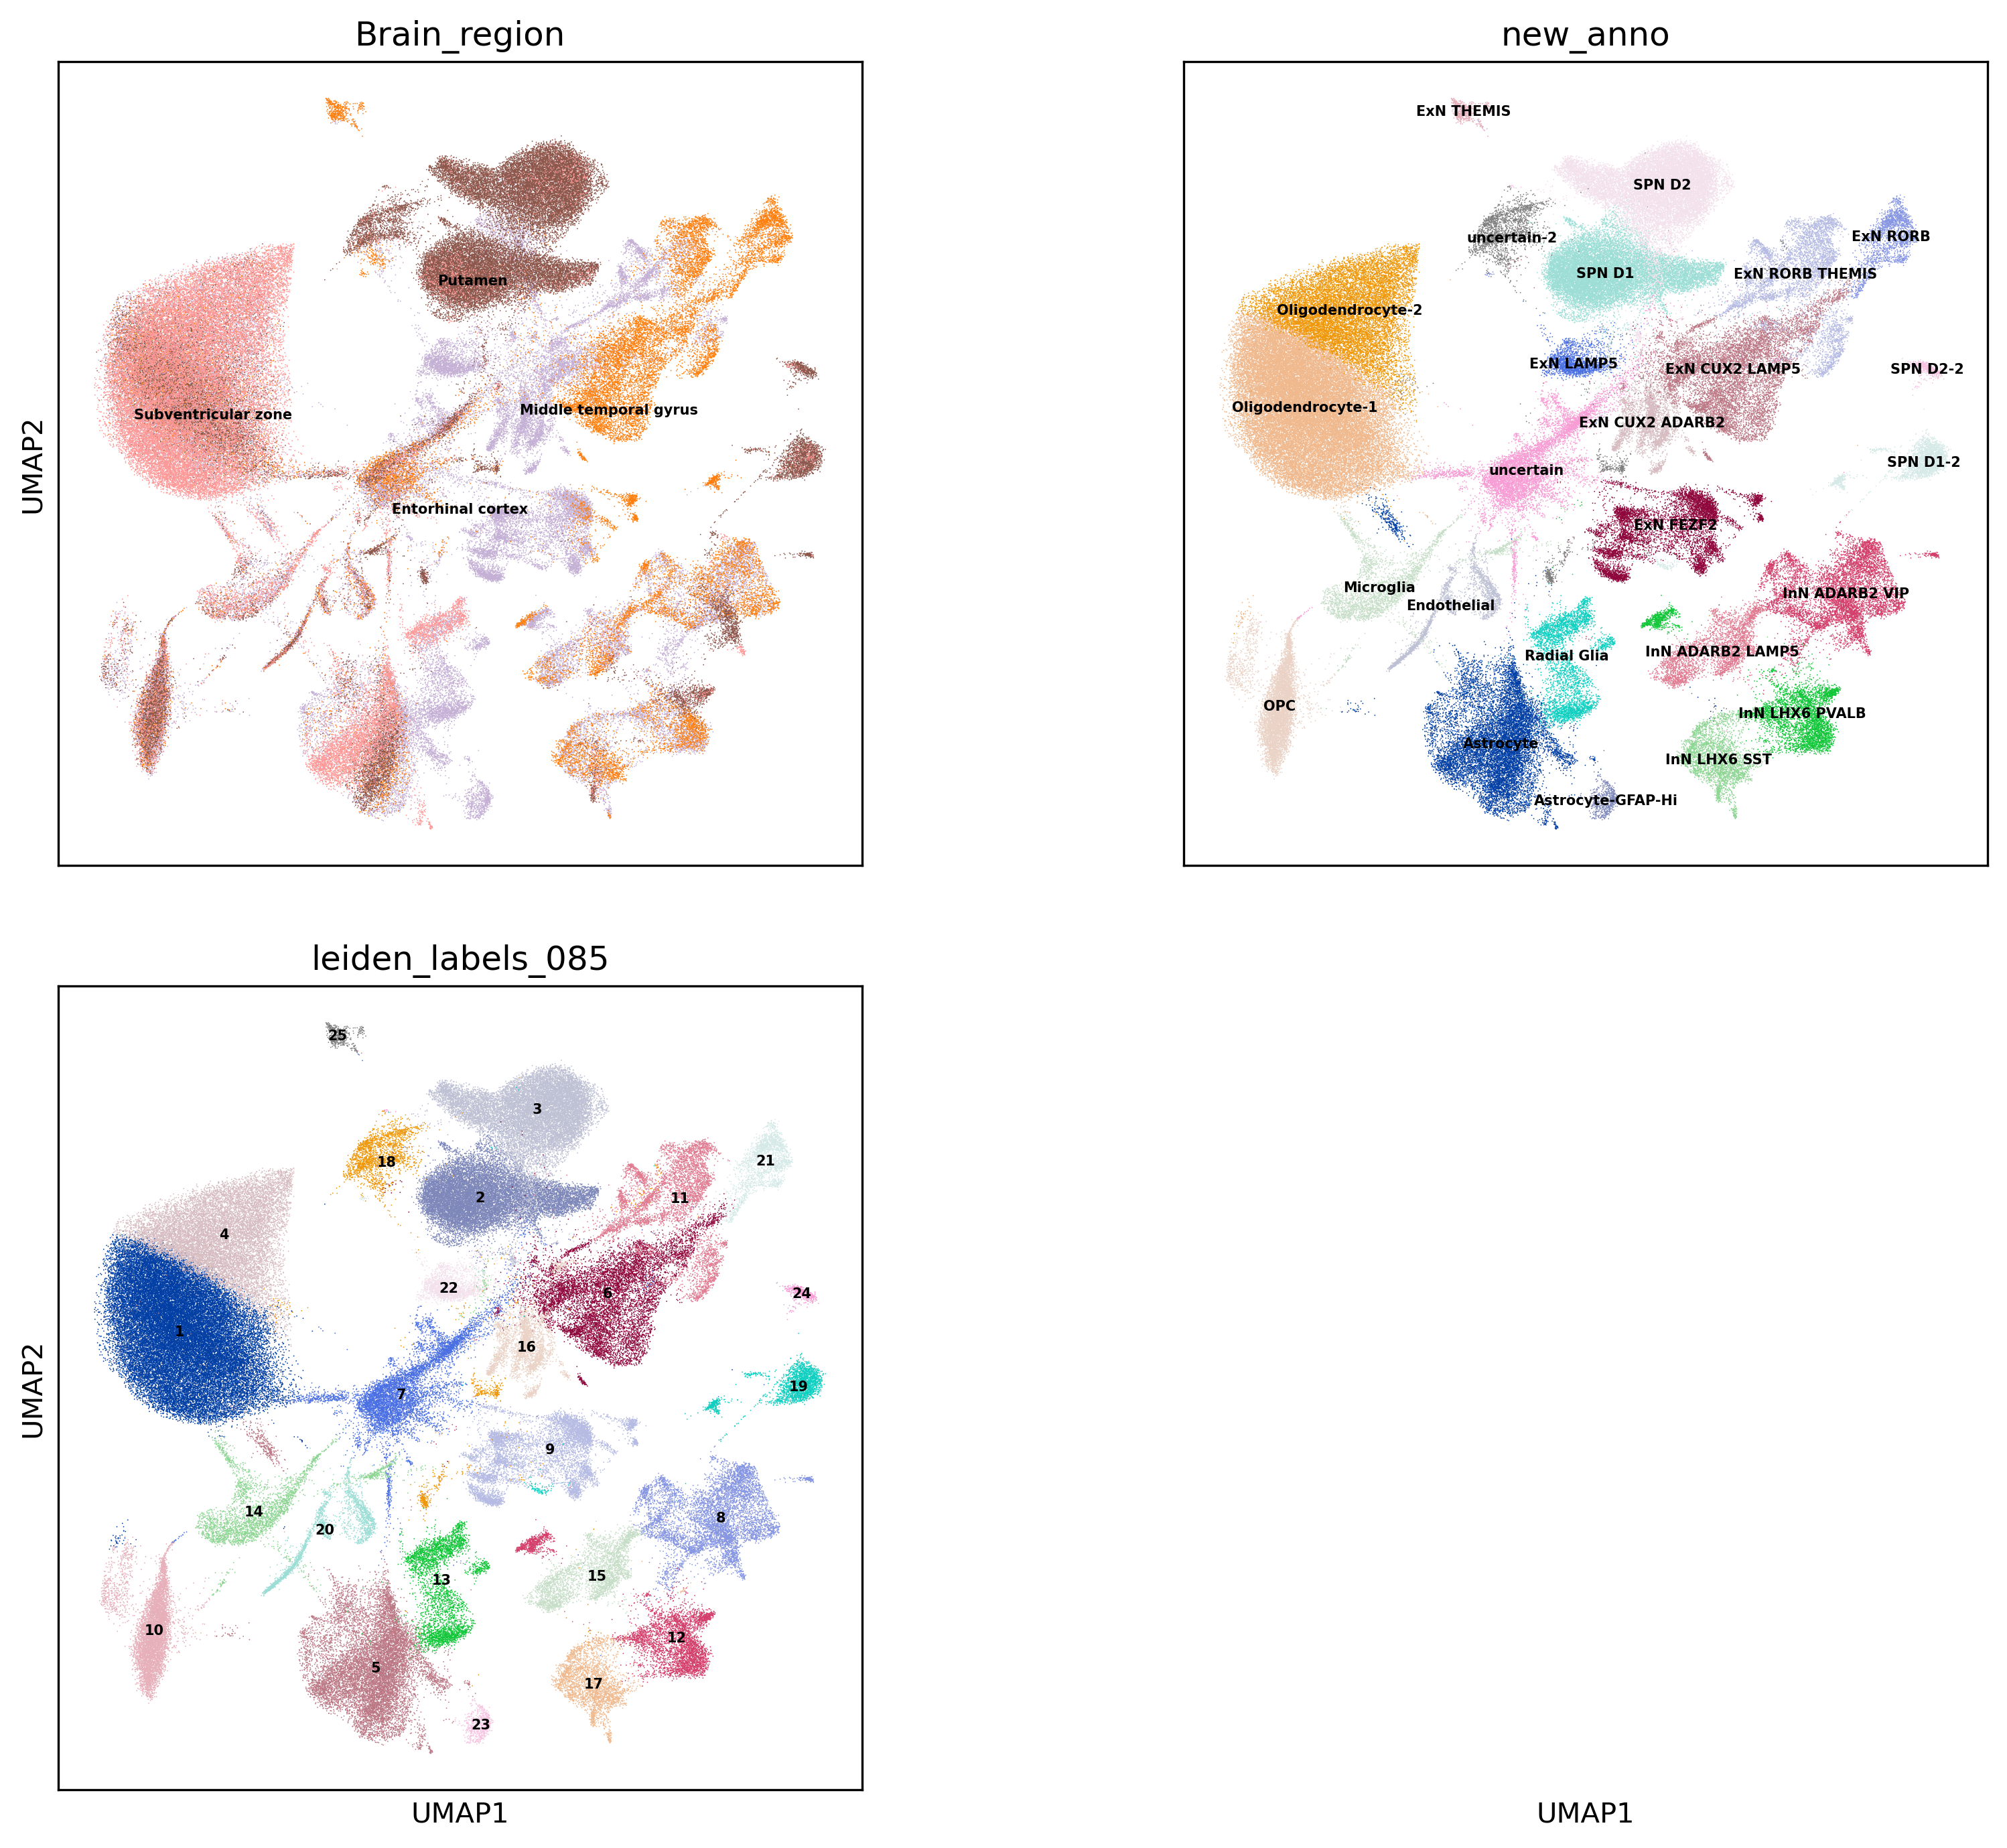

In [6]:
pg.scatter(data, attrs=categories, basis='umap', legend_loc='on data')

#### get sample counts per age group by  counts by 'categories'

In [7]:
for this_cat in categories:
    print(data.obs.groupby([this_cat,'Age_group'])['Sample_id'].nunique())

Brain_region           Age_group
Entorhinal cortex      old          6
                       young        6
Middle temporal gyrus  old          7
                       young        5
Putamen                old          7
                       young        5
Subventricular zone    old          6
                       young        6
Name: Sample_id, dtype: int64
new_anno           Age_group
Astrocyte          old          26
                   young        22
Astrocyte-GFAP-Hi  old           0
                   young         1
Endothelial        old          26
                   young        22
ExN CUX2 ADARB2    old           8
                   young         8
ExN CUX2 LAMP5     old          24
                   young        20
ExN FEZF2          old          15
                   young        13
ExN LAMP5          old           7
                   young         6
ExN RORB           old           8
                   young         8
ExN RORB THEMIS    old          14
         

#### subset cells of interest, to be re-clustered

In [8]:
# 1st Example: single grouping
# type_name = 'new_anno'
# group_name = 'Radial Glia'
# sub_data = data[data.obs[type_name] == group_name].copy()

# 2nd Example:  but probably grabbing multiple groups depending on leiden resolution
# you are working with from input, here was 0.85
type_name = 'new_anno'
group_names = ['Astrocyte', 'Radial Glia'] # ['Oligodendrocyte-1', 'Oligodendrocyte-2'] or ['uncertain', 'uncertain-2']
sub_data = data[data.obs[type_name].isin(group_names)].copy()

# 3rd Example: or similarly if doing by the pre-existing leiden labels
# type_name = 'leiden_labels_085'
# group_names = [3, 5, 15]
# sub_data = data[data.obs[type_name].isin(group_names)].copy()

#### visualize existing clusters for subset cells

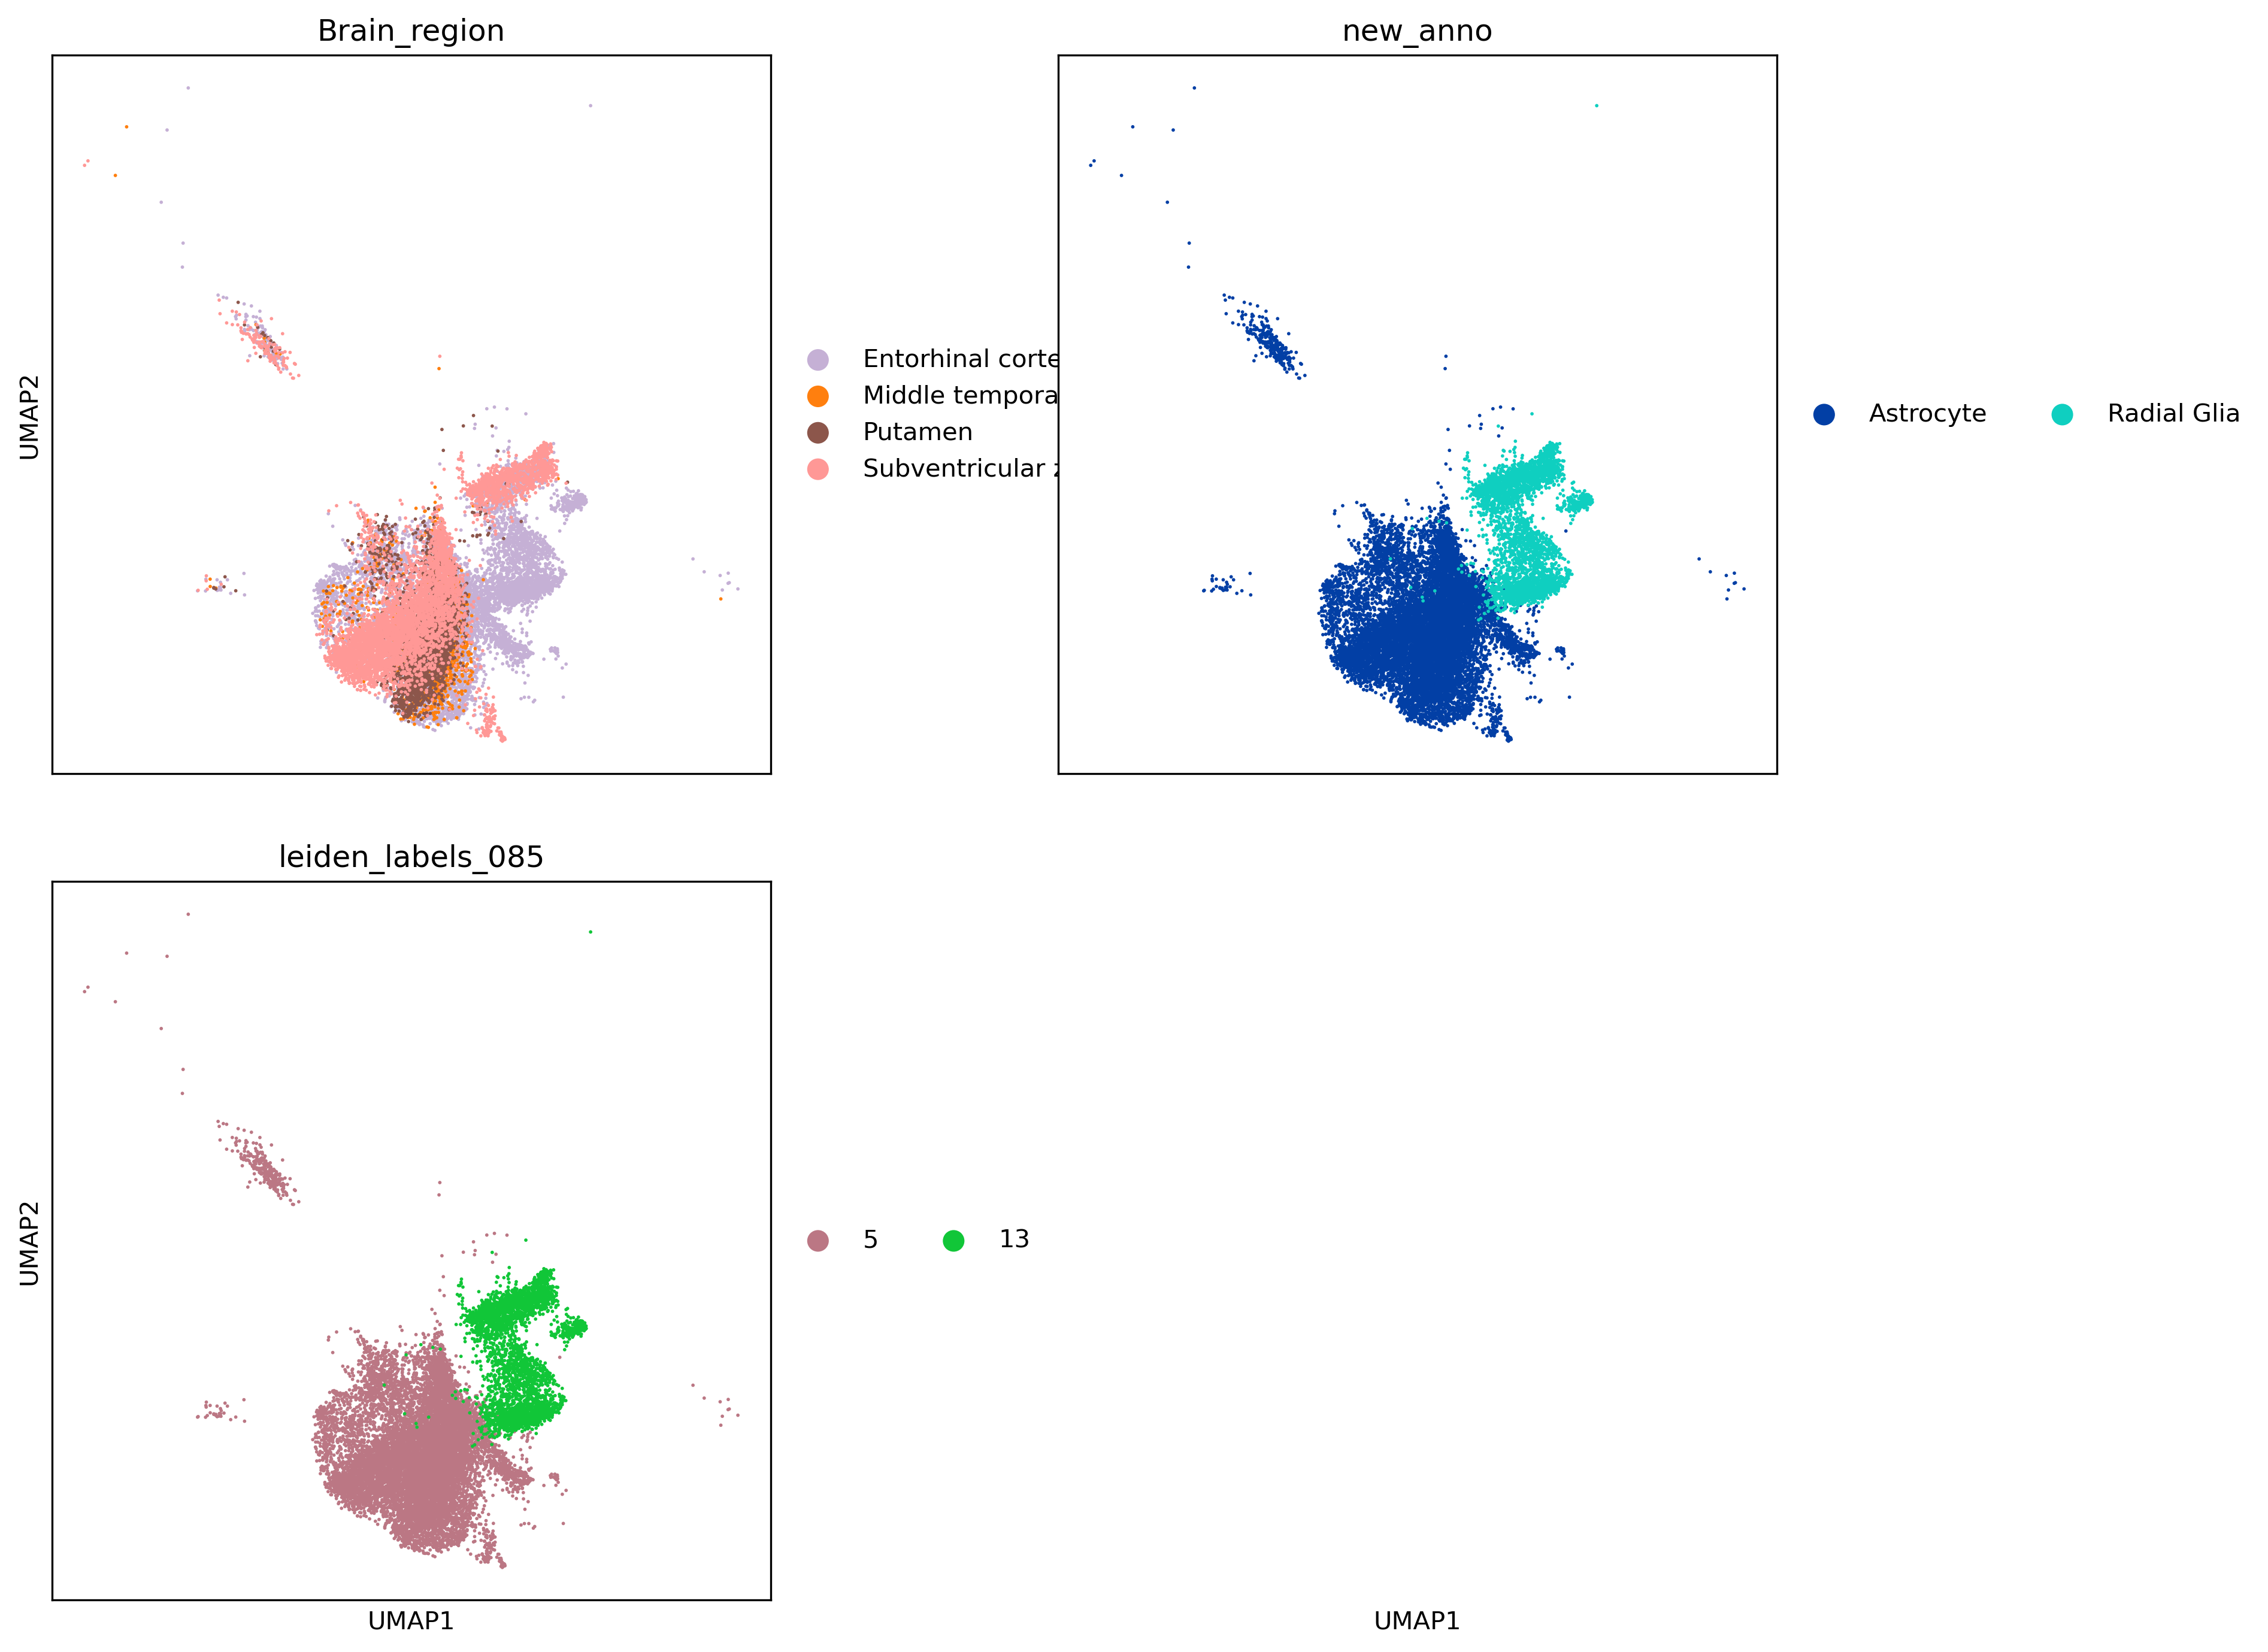

In [9]:
pg.scatter(sub_data, attrs=categories, basis='umap')

#### re-cluster the subset data (cells)

since we've subset from the Pegasus analysis, that did batch correction with Harmony, we are still using the same Harmony correction info, from Pegasus notebook markdown
from that notebook:
- `pca_key` is the representation key returned by `run_harmony` function, which is equivalent to string `"pca_harmony"`. In the following sections, you can use either `pca_key` or `"pca_harmony"` to specify `rep` parameter in Pegasus functions whenever applicable.

In [10]:
pg.neighbors(sub_data, rep="pca_harmony")

2021-10-11 12:12:23,803 - pegasus.tools.nearest_neighbors - INFO - Function 'get_neighbors' finished in 2.03s.
2021-10-11 12:12:24,292 - pegasus.tools.nearest_neighbors - INFO - Function 'calculate_affinity_matrix' finished in 0.49s.


In [11]:
# here you can alter resolution as desired
this_res = leiden_resolution
# this_res = 0.3
this_label = f'sub_leid_{this_res}'
this_label = this_label.replace('.', '_')
pg.leiden(sub_data, rep="pca_harmony", resolution=this_res, 
          class_label=this_label)

2021-10-11 12:12:24,892 - pegasus.tools.graph_operations - INFO - Function 'construct_graph' finished in 0.59s.
2021-10-11 12:12:26,451 - pegasus.tools.clustering - INFO - Leiden clustering is done. Get 3 clusters.
2021-10-11 12:12:26,528 - pegasus.tools.clustering - INFO - Function 'leiden' finished in 2.23s.


#### visualize sub-clustering

In [12]:
pg.umap(sub_data, rep="pca_harmony")

2021-10-11 12:12:26,533 - pegasus.tools.nearest_neighbors - INFO - Found cached kNN results, no calculation is required.
2021-10-11 12:12:26,534 - pegasus.tools.nearest_neighbors - INFO - Function 'get_neighbors' finished in 0.00s.
2021-10-11 12:12:26,543 - pegasus.tools.visualization - INFO - UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.5, random_state=0, verbose=True)
2021-10-11 12:12:26,543 - pegasus.tools.visualization - INFO - Construct fuzzy simplicial set
2021-10-11 12:12:28,675 - pegasus.tools.visualization - INFO - Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
2021-10-11 12:12:41,504 - pegasus.tools.visualization - INFO - Function 'umap' finished in 14.97s.


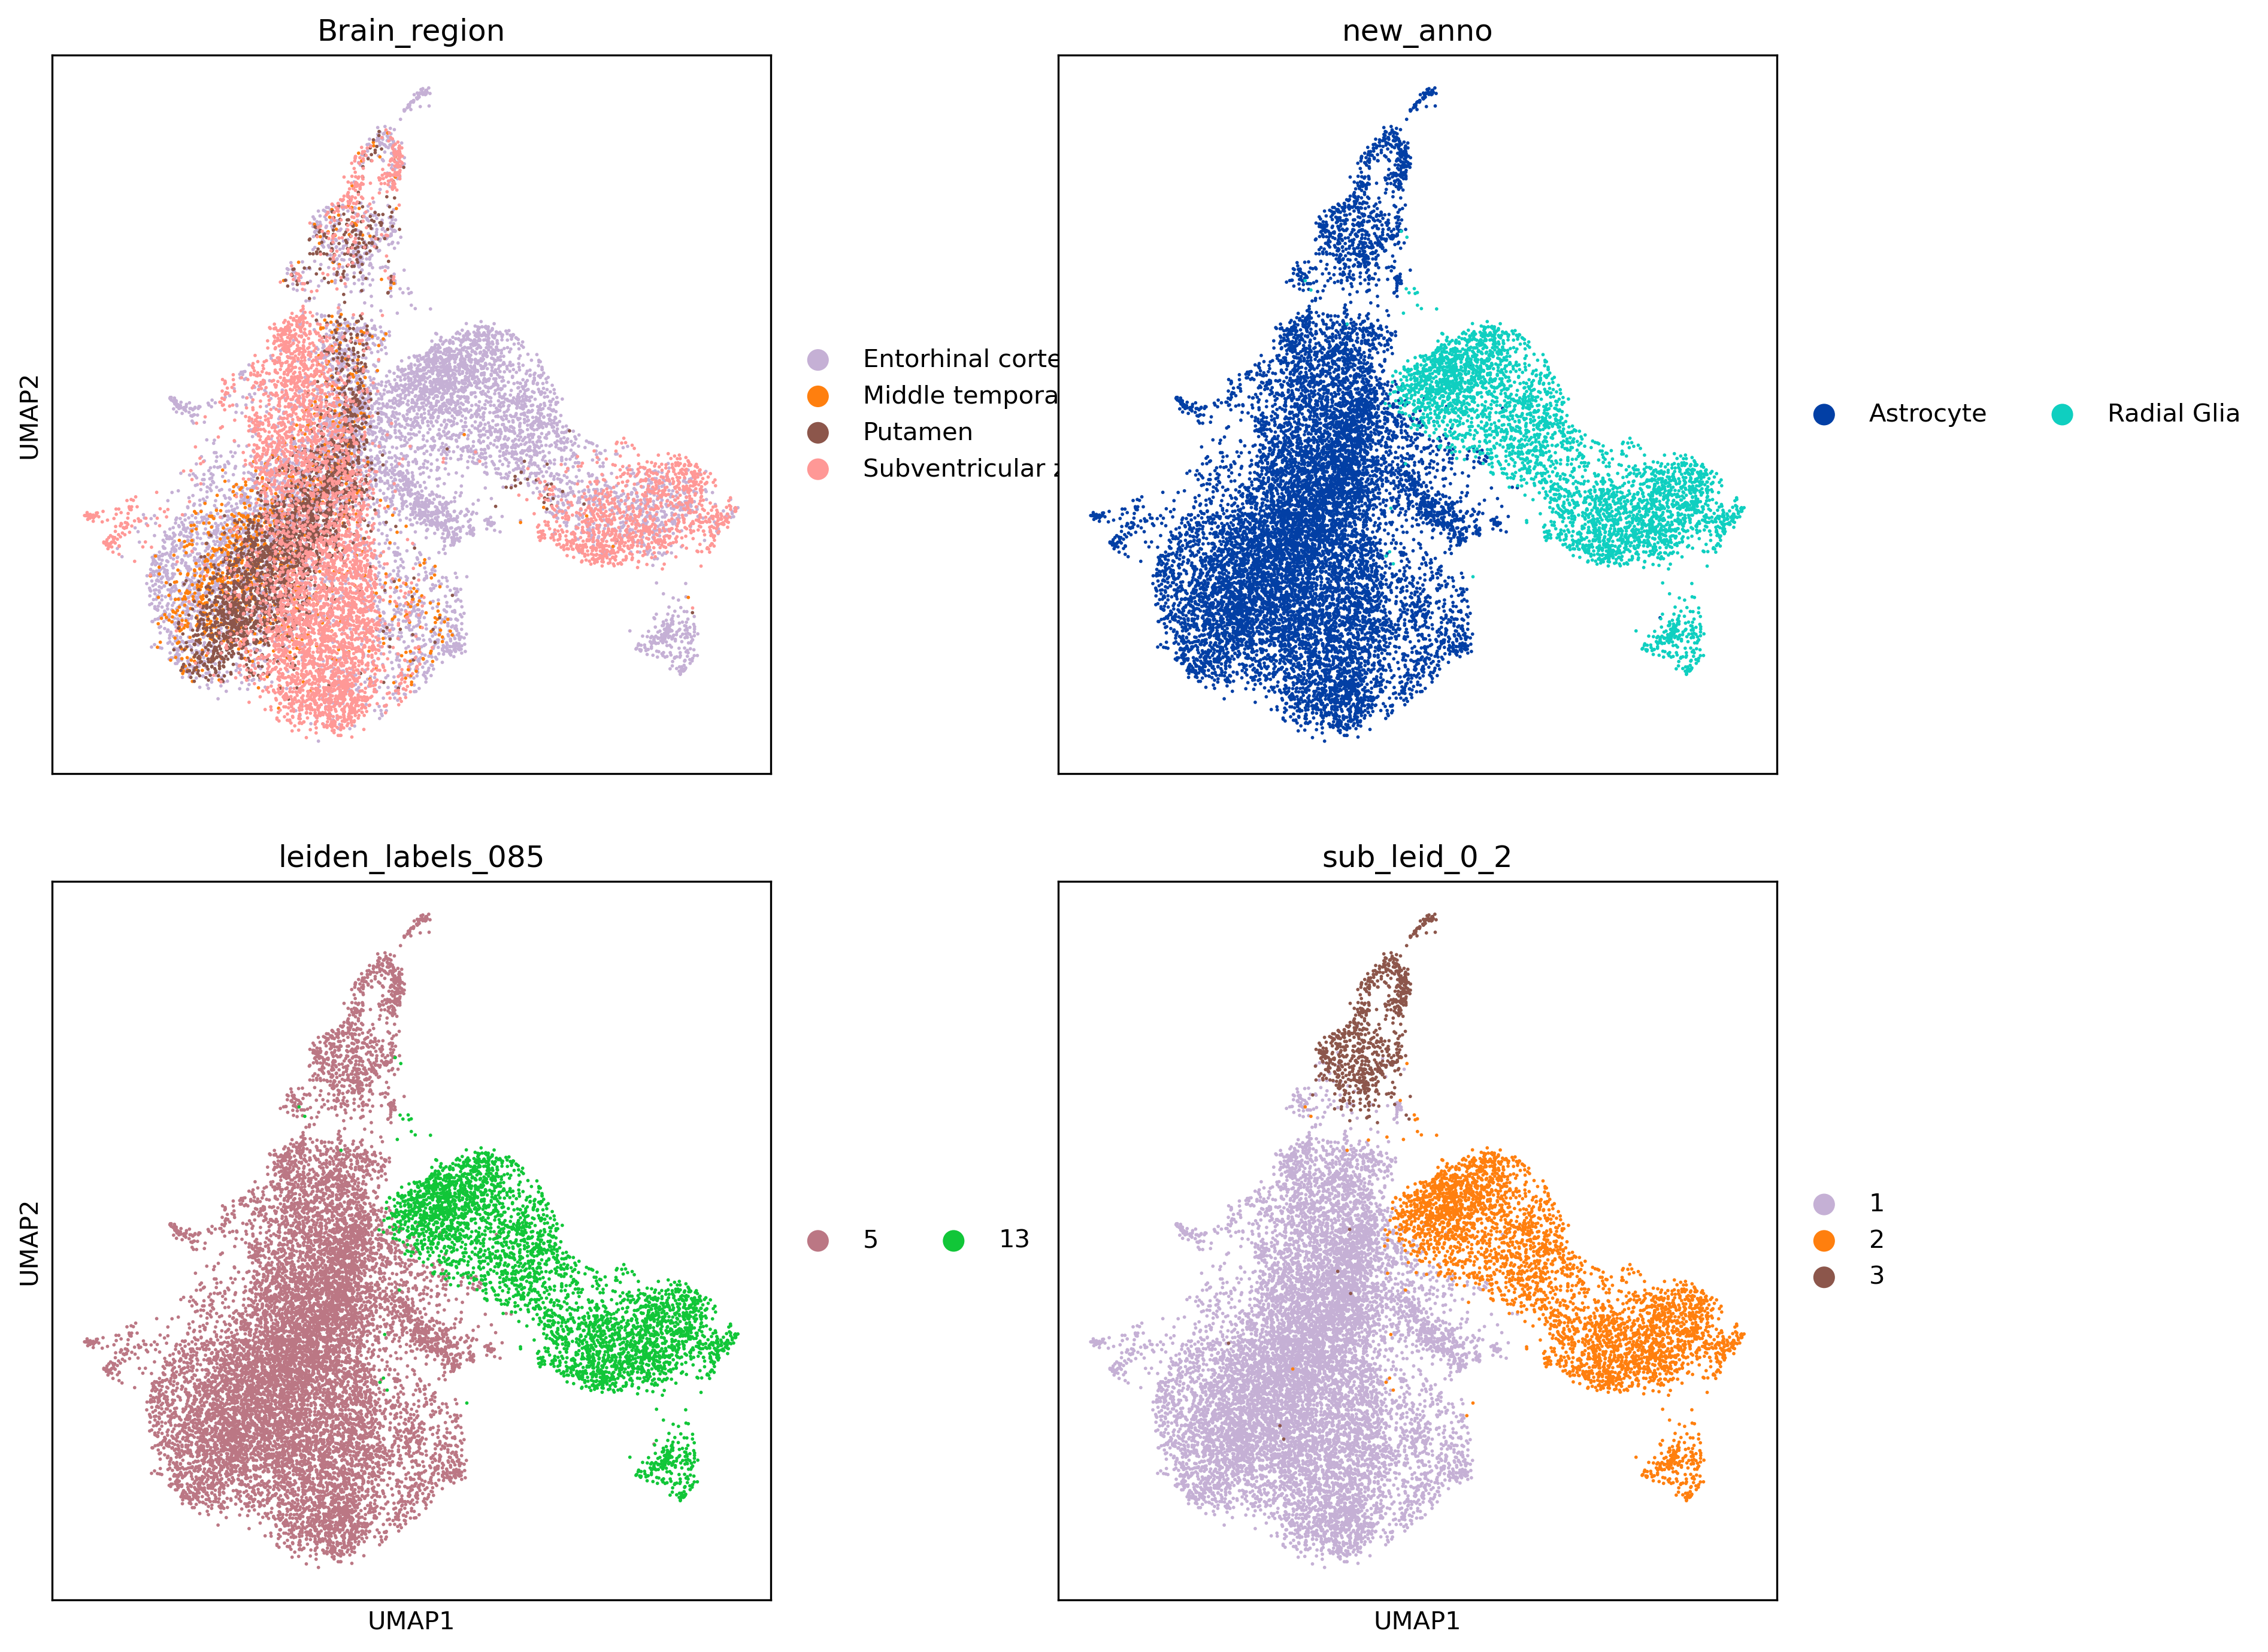

In [13]:
pg.scatter(sub_data, attrs=categories + [this_label], basis='umap')

## Differential Expression Analysis

With the clusters ready, we can now perform Differential Expression (DE) Analysis. DE analysis is to discover cluster-specific marker genes. For each cluster, it compares cells within the cluster with all the others, then finds genes significantly highly expressed (up-regulated) and lowly expressed (down-regulated) for the cluster.

Now use `de_analysis` method to run DE analysis. We use Louvain result here. 

In [14]:
pg.de_analysis(sub_data, cluster=this_label)

2021-10-11 12:12:42,956 - pegasus.tools.diff_expr - INFO - CSR matrix is converted to CSC matrix. Time spent = 0.3618s.


2021-10-11 12:12:47.352999: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 12:12:47.433060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 12:12:47.483019: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 12:12:47.490944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 12:12:47.526207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 12:12:47.537001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 12:12:47.558951: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic libr

2021-10-11 12:12:50,280 - pegasus.tools.diff_expr - INFO - MWU test and AUROC calculation are finished. Time spent = 7.3239s.
2021-10-11 12:12:50,434 - pegasus.tools.diff_expr - INFO - Sufficient statistics are collected. Time spent = 0.1533s.
2021-10-11 12:12:50,470 - pegasus.tools.diff_expr - INFO - Differential expression analysis is finished.
2021-10-11 12:12:50,471 - pegasus.tools.diff_expr - INFO - Function 'de_analysis' finished in 7.88s.


By default, DE analysis runs Mann-Whitney U (MWU) test.

Alternatively, you can also run the follow tests by setting their corresponding parameters to be `True`:
* `fisher`: Fisher’s exact test.
* `t`: Welch’s T test.

DE analysis result is stored with key `"de_res"` (by default) in `varm` field of data. See [documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.de_analysis.html) for more details. 

To load the result in a human-readable format, use `markers` method:

In [15]:
marker_dict = pg.markers(sub_data)

By default, `markers`:
* Sort genes by Area under ROC curve (AUROC) in descending order;
* Use $\alpha = 0.05$ significance level on q-values for inference.

See [documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.markers.html) for customizing these parameters.

Let's see the up-regulated genes for Cluster 1, and rank them in descending order with respect to log fold change:

In [33]:
marker_dict['3']['up'].sort_values(by='log2FC', ascending=False)

log2Mean  log2Mean_other    log2FC  percentage  percentage_other  \
feature                                                                        
ST18        7.089265        1.151319  5.937946      96.750         23.890694   
SLC24A2     6.873505        1.219454  5.654051      97.375         24.885588   
MBP         6.740053        1.099660  5.640393      96.375         22.862638   
CTNNA3      7.757854        2.276588  5.481266      98.625         44.080387   
ELMO1       6.289260        0.955435  5.333826      94.750         19.287657   
...              ...             ...       ...         ...               ...   
AC148477.1  0.001481        0.000000  0.001481       0.125          0.000000   
AC092192.1  0.001481        0.000000  0.001481       0.125          0.000000   
FOXQ1       0.001481        0.000279  0.001202       0.125          0.006633   
TRPM2-AS    0.001481        0.000304  0.001176       0.125          0.006633   
AL355596.1  0.001481        0.000329  0.001152       0.125          0.006633   

            percentage_fold_change     auroc       mwu_U  mwu_pval  mwu_qval  
feature                                                                       
ST18                  4.049694e+00  0.965068  11640269.0  0.000000  0.000000  
SLC24A2               3.912907e+00  0.963806  11625041.0  0.000000  0.000000  
MBP                   4.215393e+00  0.960858  11589484.5  0.000000  0.000000  
CTNNA3                2.237390e+00  0.972658  11731809.5  0.000000  0.000000  
ELMO1                 4.912468e+00  0.945685  11406469.0  0.000000  0.000000  
...                            ...       ...         ...       ...       ...  
AC148477.1            1.000000e+30  0.500625   6038338.5  0.000014  0.000121  
AC092192.1            1.000000e+30  0.500625   6038338.5  0.000014  0.000121  
FOXQ1                 1.884625e+01  0.500592   6037938.0  0.003655  0.018384  
TRPM2-AS              1.884625e+01  0.500592   6037938.0  0.003655  0.018384  
AL355596.1            1.884625e+01  0.500592   6037938.0  0.003655  0.018384  

[5521 rows x 10 columns]

We can also use Volcano plot to see the DE result. Below is such a plot w.r.t. each Cluster with MWU test results (by default):

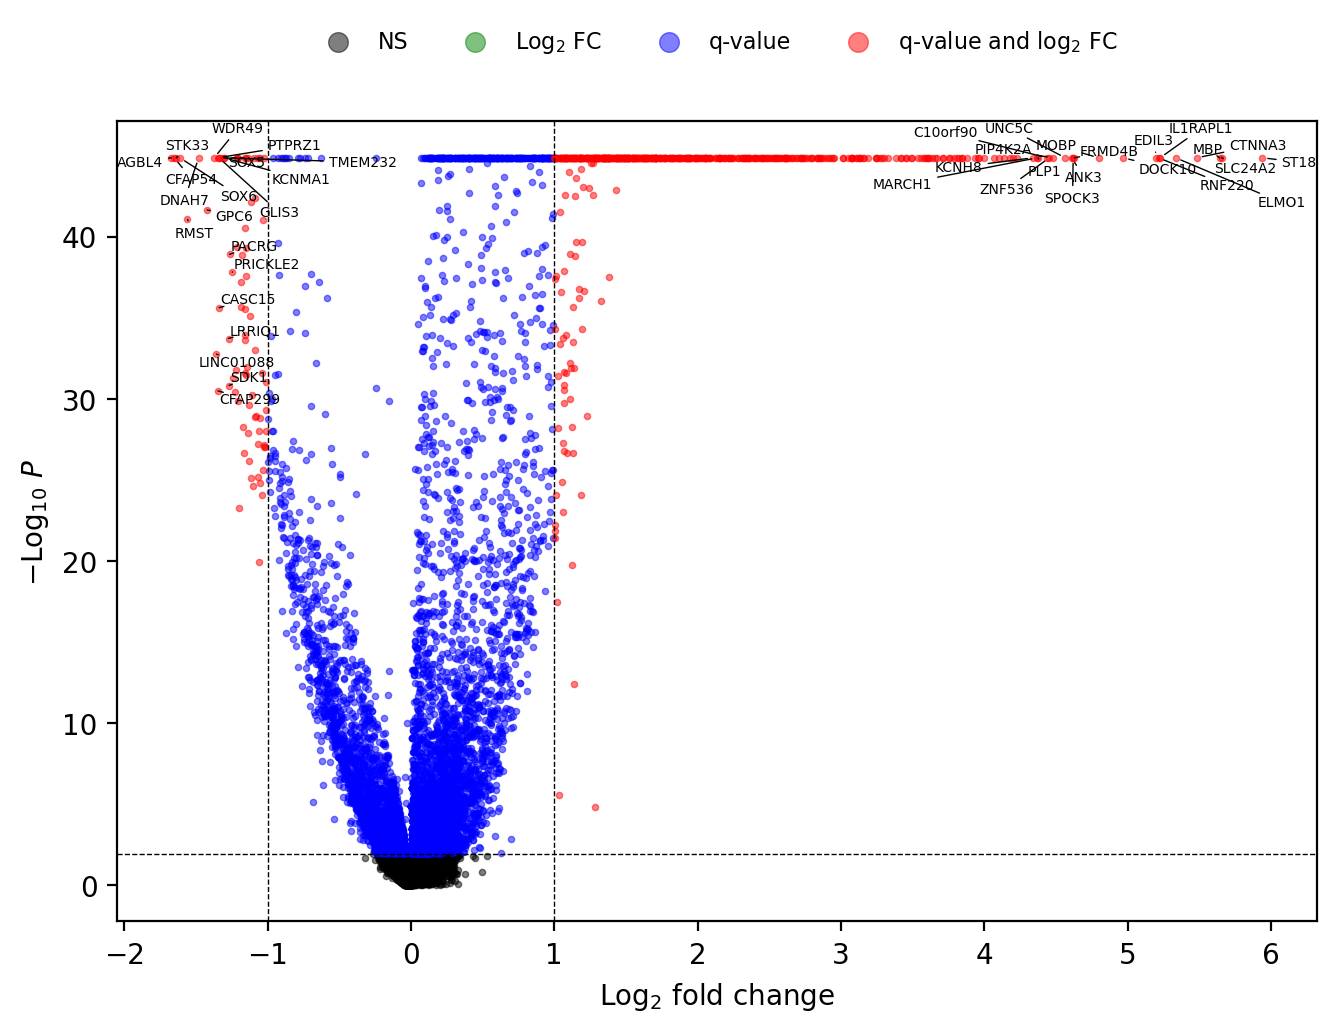

In [17]:
pg.volcano(sub_data, cluster_id=3, dpi=200)

The plot above uses the default thresholds: log fold change at $1$ (i.e. fold change at $2$), and q-value at $0.05$. Each point stands for a gene. Red ones are significant marker genes: those at right-hand side are up-regulated genes for Cluster 1, while those at left-hand side are down-regulated genes.

## Cell Type Annotation

After done with DE analysis, we can use the test result to annotate the clusters.

In [18]:
markers_json

'/labshare/raph/datasets/adrd_neuro/aging/expression/human_brain_cell_markers_LNG.json'

#### here I've lowered threshold from default 0.5 to 0.05, to see without threshold what label would be

In [19]:
celltype_dict = pg.infer_cell_types(sub_data, markers=markers_json, threshold=0.05)
cluster_names = pg.infer_cluster_names(celltype_dict)

`infer_cell_types` has 2 critical parameters to set:
* `markers`: Either `'human_immune'`, `'mouse_immune'`, `'human_brain'`, `'mouse_brain'`, `'human_lung'`, or a user-specified marker dictionary.
* `de_test`: Decide which DE analysis test to be used for cell type inference. It can be either `'t'`, `'fisher'`, or `'mwu'`. Its default is `'mwu'`.

`infer_cluster_names` by default uses `threshold = 0.5` to filter out candidate cell types of scores lower than 0.5.

See [documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.infer_cell_types.html) for details.

Below is the cell type annotation report for each Cluster:

In [20]:
sub_data.obs[this_label].value_counts()

1    11365
2     3712
3      800
Name: sub_leid_0_2, dtype: int64

In [21]:
for leid_label in sub_data.obs[this_label].unique():
    print(leid_label)
    print(celltype_dict[leid_label])

1
[name: Astrocyte; score: 0.92; average marker percentage: 59.43%; strong support: (GFAP+,58.87%),(APOE+,37.99%),(SLC1A2+,85.62%),(SLC14A1+,64.86%),(CPE+,83.31%),(CLU+,71.03%),(AQP4+,78.29%); weak support: (SLC1A3+,95.26%),(ALDOC+,11.54%),(GJB6+,7.52%), name: OPC_ODC; score: 0.40; average marker percentage: 49.68%; strong support: (VCAN+,45.34%),(CNTN1+,84.32%); weak support: (TNR+,19.38%), name: Mural; score: 0.25; average marker percentage: 48.49%; strong support: (PDGFRB+,27.99%),(PTN+,38.71%),(ATP1A2+,78.79%), name: Neuron; score: 0.17; average marker percentage: 31.30%; strong support: (CAMK2B+,31.30%), name: Endothelial; score: 0.14; average marker percentage: 20.21%; weak support: (COLEC12+,31.67%),(APOLD1+,8.75%), name: Oligodendrocyte; score: 0.12; average marker percentage: 26.07%; strong support: (CRYAB+,26.07%), name: Microglia; score: 0.07; average marker percentage: 5.13%; weak support: (CSF1R+,1.16%),(P2RY12+,9.10%)]
3
[name: Oligodendrocyte; score: 0.96; average marker

The report has a list of predicted cell types along with their scores and support genes for users to decide.

Next, substitute the inferred cluster names in data using `annotate` function:

In [22]:
pg.annotate(sub_data, name='sub_anno', based_on=this_label, anno_dict=cluster_names)
sub_data.obs['sub_anno'].value_counts()

Astrocyte          11365
2                   3712
Oligodendrocyte      800
Name: sub_anno, dtype: int64

So the cluster-specific cell type information is stored in `data.obs['anno']`.

The `anno_dict` can be either a list or a dictionary. If provided a list (which is the case here), Pegasus will match cell types with cluster labels in the same order. Alternatively, you can create an annotation dictionary with keys being cluster labels and cell types being values.

In practice, users may want to manually create this annotation structure by reading the report in `celltype_dict`. In this tutorial, we'll just use the output of `infer_cluster_names` function for demonstration.

Now plot the data with cell types:

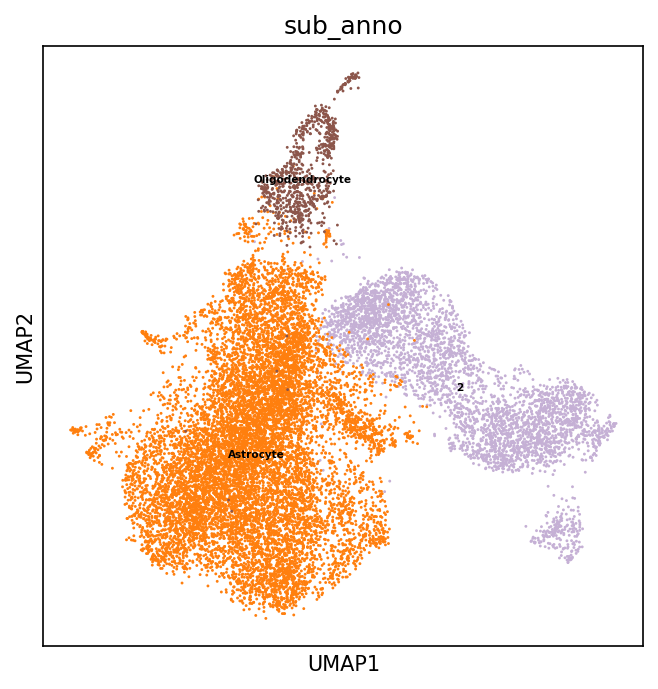

In [23]:
pg.scatter(sub_data, attrs='sub_anno', basis='umap', legend_loc='on data', dpi=150)

#### so cluster 2, wasn't IDed for cell-type
where cluster 2 contains the Entorhinal cortex 'radial glia(?)'

can we use GSEA to auto-ID cell-types

In [24]:
import gseapy

In [25]:
# gbm_marker_dict = pg.find_markers(sub_data, label_attr=this_label)
# pg.find_markers(sub_data, label_attr=this_label, random_state=42, remove_ribo=True)

In [26]:
this_leid_cluster = '2'
top_gene_cnt = 25

up_markers = marker_dict[this_leid_cluster]['up']
up_2fc_sig = up_markers.loc[(up_markers['log2FC'] > 2) & up_markers['mwu_qval'] < 0.05]
print(up_2fc_sig.shape)

display(up_2fc_sig.sort_values(by='log2FC', ascending=False).head())

(13589, 10)


log2Mean  log2Mean_other    log2FC  percentage  percentage_other  \
feature                                                                     
CFAP299  5.142363        0.600920  4.541442   65.651939         11.171393   
SDK1     6.065169        1.555194  4.509975   91.298492         29.132757   
RMST     7.063722        2.670038  4.393683   96.390083         48.121662   
SLIT2    4.825184        0.698043  4.127142   80.441811         13.177148   
SPAG17   4.552358        0.521352  4.031006   69.719826         10.464447   

         percentage_fold_change     auroc       mwu_U  mwu_pval  mwu_qval  
feature                                                                    
CFAP299                5.876791  0.799402  36098187.0       0.0       0.0  
SDK1                   3.133878  0.892434  40299190.5       0.0       0.0  
RMST                   2.003050  0.897402  40523500.0       0.0       0.0  
SLIT2                  6.104645  0.853771  38553311.5       0.0       0.0  
SPAG17                 6.662543  0.821305  37087221.0       0.0       0.0

In [27]:
gene_list = list(up_2fc_sig.sort_values(by='log2FC', ascending=False).head(top_gene_cnt).index.values)

In [28]:
gene_set_names = gseapy.get_library_name(database='Human')

(115, 10)


Gene_set                                       Term  \
0  CellMarker_Augmented_2021         Ciliated Epithelial cell:Esophagus   
1  CellMarker_Augmented_2021                  Primordial Germ cell:Germ   
2  CellMarker_Augmented_2021                Pigment Epithelial cell:Eye   
3  CellMarker_Augmented_2021  PROM1High Progenitor cell:Large Intestine   
4  CellMarker_Augmented_2021     DCLK1+ Progenitor cell:Large Intestine   

  Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  11/425  1.196523e-12      1.376002e-10            0                     0   
1    3/92  2.013145e-04      9.871390e-03            0                     0   
2   3/100  2.575145e-04      9.871390e-03            0                     0   
3    2/96  6.365686e-03      4.486847e-02            0                     0   
4    2/98  6.624998e-03      4.486847e-02            0                     0   

   Odds Ratio  Combined Score  \
0   37.124051     1019.114634   
1   30.468846      259.309442   
2   27.944705      230.947181   
3   18.391304       93.001760   
4   18.006341       90.336103   

                                               Genes  
0  ADGB;SPAG17;ARMC3;LRRIQ1;DNAH6;ZBBX;HYDIN;DNAH...  
1                                   ZBBX;HYDIN;DNAH9  
2                                 ZBBX;STK32A;CFAP43  
3                                       COL8A1;SLIT2  
4                                       LAMA2;COL8A1

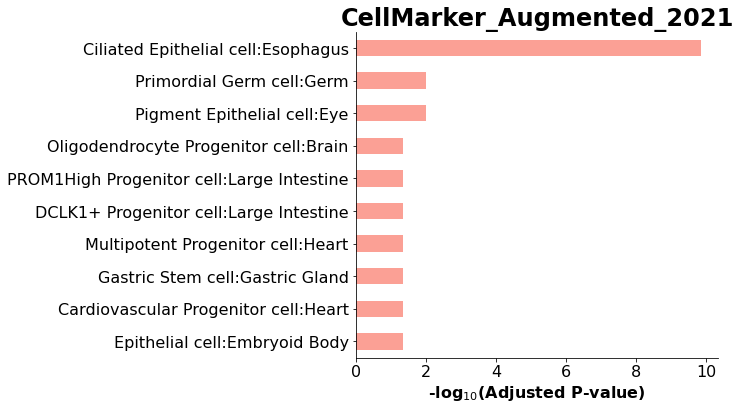

In [29]:
gene_set = 'CellMarker_Augmented_2021'
enr_res = gseapy.enrichr(gene_list=gene_list,
                         organism='Human',
                         gene_sets=gene_set,
                         description='pathway',
                         cutoff = 0.5)
print(enr_res.results.shape)
display(enr_res.results.head())
gseapy.barplot(enr_res.res2d,title=gene_set)

In [30]:
gene_set = 'Allen_Brain_Atlas_10x_scRNA_2021'
enr_res = gseapy.enrichr(gene_list=gene_list,
                         organism='Human',
                         gene_sets=gene_set,
                         description='pathway',
                         cutoff = 0.5)
print(enr_res.results.shape)
display(enr_res.results.head())
gseapy.barplot(enr_res.res2d,title=gene_set)

(67, 10)


Gene_set                              Term Overlap  \
0  Allen_Brain_Atlas_10x_scRNA_2021                 Mouse 371 Peri up    2/44   
1  Allen_Brain_Atlas_10x_scRNA_2021  Human Exc L2-3 LINC00507 DSG3 up   3/184   
2  Allen_Brain_Atlas_10x_scRNA_2021                  Mouse 297 CA3 up   2/105   
3  Allen_Brain_Atlas_10x_scRNA_2021    Human Exc L5 THEMIS FGF10 down     1/7   
4  Allen_Brain_Atlas_10x_scRNA_2021     Human Exc L3-5 RORB LNX2 down     1/8   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.001374          0.050849            0                     0   41.269151   
1  0.001518          0.050849            0                     0   14.912607   
2  0.007570          0.133437            0                     0   16.776699   
3  0.008718          0.133437            0                     0  138.673611   
4  0.009958          0.133437            0                     0  118.857143   

   Combined Score               Genes  
0      271.961682         LAMA2;PLCL1  
1       96.789279  HYDIN;DNAH9;CFAP54  
2       81.930170         HTR2C;DNAH9  
3      657.633561            KIAA1217  
4      547.857721            KIAA1217

'Warning: No enrich terms using library Allen_Brain_Atlas_10x_scRNA_2021 when cutoff = 0.05'

In [31]:
sub_data

UnimodalData object with n_obs x n_vars = 15877 x 35441
    Genome: unknown; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'X' as X

    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group', 'sub_leid_0_2', 'sub_anno'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X_umap_085'
    varm: 'de_res', 'gmeans', 'gstds', 'means', 'partial_sum'
    uns: 'genome', 'modality', 'pca_features', 'pca_harmony_knn_indices', 'pca_harmony_knn_distances', 'W_pca_harmony', 'leiden_resolution'

In [32]:
this_label

'sub_leid_0_2'